# Why you shouldn't track metrics by calendar month

This is a topic that has come up a number of times in my career. Folks want to measure how users are using their product in a variety of ways, and some of those ways include longer-term metrics. It's natural to want to measure these longer-term metrics by calendar months, but doing so can introduce noise, be misleading, and lead to incorrect conclusions. We'll explore this with two standard metrics: monthly active users (**MAU**) and next-month **retention**.

## Why?

The problem with tracking metrics by calendar month is that the number of days in a month varies. This means that seasonality/noise will be artificially introduced because each month is effectively using a different measuring stick. This will be fairly obvious for MAU, but it can be less obvious for retention. We'll explore this in more detail below.

Tracking retention by calendar month typically means determining if someone is retained if we see them return in the next calendar month, and this is misleading because it's not a true measure of if the user came back a month later. If a user first appeared on January 31st and came back on February 1st, then they would count as being next-month retained despite only being next-day retained.

Lastly, tracking metrics by calendar month causes a delay in reporting. If you want to report on January's metrics, you have to wait until February 1st to get the full picture. Metrics often need to be reported in a timely manner, so having to wait until the end of the month to see how metrics performed during that month is obviously problemtatic.

## The solution: Rolling *n*-day periods

The preferred way of tracking monthly metrics is to use rolling *n*-day periods. This means that you measure the metric over the last *n* days, and then move the window forward by one day when re-calculating the next day. This is a more accurate way of measuring metrics because it removes the noise introduced by the varying number of days in a month.

The two most common values for *n* are 28 and 30. 28 is used because it's the average number of days in a month, and 30 is used because it's a nice round number. We'll stick with 28 for this post, but it's usually best to align with what other teams in your company are using so you can make comparisons when necessary.

We're also going to update our retention calculation for this. Specifically, we'll measure next-month retention by if a user re-appeared 28-56 days later. This is a more accurate measure of if the user actually came back a month later.

It's worth noting that there is one small advantages to tracking metrics by calendar month over rolling *n*-day periods - they are easier to understand and communicate. If someone asks "How many users did we have in November?" it's more straightforward to give a number than having qualify it with "We had *n* users in the last 28 days as of November 30th".

## Case study

Let's look at a case study to compare these two methods. We'll create a dataset of hypothetical user activity from a website or app. We'll simulate their retention rates and compare MAU and retention by calendar month vs. rolling 28-day periods.

We'll keep the rate of users per day and the true retention rates constant so we can remove additional noise when comparing the two methods. We're also going to assume that users can't appear more than once in a 28 day period for simplicity - there are ways to handle this but it's not the focus of this post.

### Monthly Active Users (MAU)

As a reminder, we're going to have a constant rate of users per day and assume that users can't appear more than once in a 28 day period for simplicity.

In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

# Putting together a data frame with a row for each day in the year
days_in_year = pd.date_range('2023-01-01', '2023-12-31', freq='D')
df = pd.DataFrame(days_in_year, columns=['Date'])
df['MonthName'] = df['Date'].dt.month_name()
df['Month'] = df['Date'].dt.strftime('%Y-%m')
df['MonthNum'] = df['Date'].dt.month
df['NumUsers'] = 3000

df

,Date,MonthName,Month,MonthNum,NumUsers
0,2023-01-01,January,2023-01,1,3000
1,2023-01-02,January,2023-01,1,3000
2,2023-01-03,January,2023-01,1,3000
3,2023-01-04,January,2023-01,1,3000
4,2023-01-05,January,2023-01,1,3000
...,...,...,...,...,...
360,2023-12-27,December,2023-12,12,3000
361,2023-12-28,December,2023-12,12,3000
362,2023-12-29,December,2023-12,12,3000
363,2023-12-30,December,2023-12,12,3000


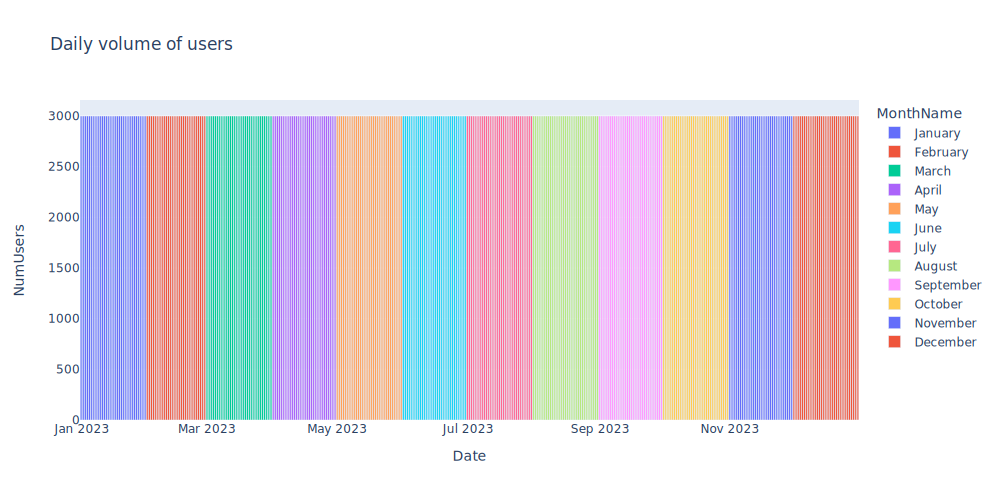

In [2]:
# Quick look at the daily users over time
fig = px.bar(df, x='Date', y='NumUsers', color='MonthName',
             title='Daily volume of users', width=1000, height=500)
fig.show(renderer='svg')  # To render in notebooks on GitHub

#### By calendar month

MAU (monthly active users) is just the number of users in a given month, so we can calculate this with a quick groupby.

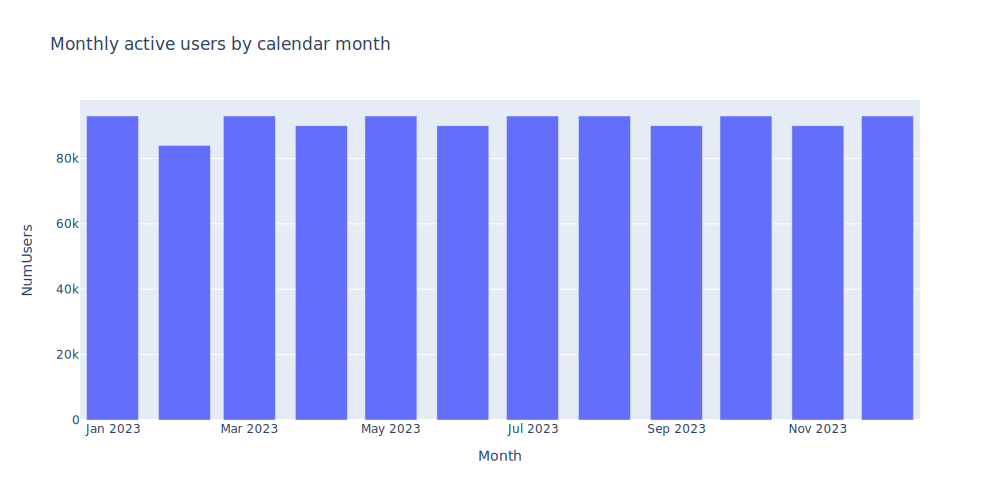

In [3]:
# Calculating MAU by calendar month
MAU_calendar_month = df.groupby('Month')['NumUsers'].sum().reset_index()
fig = px.bar(MAU_calendar_month, x='Month', y='NumUsers', title='Monthly active users by calendar month', width=1000, height=500)
fig.show('svg')

That looks like quite a bit of variation. A natural question is to ask how much this is changing each month, so we'll calculate the percent change from the previous month. We'll make a function to do this since we'll be doing it a few times in this post.

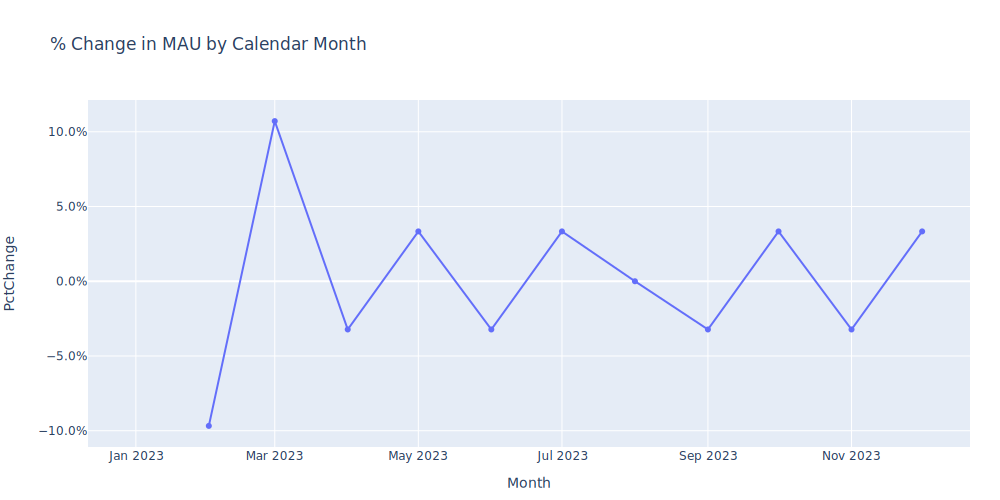

In [4]:
def pct_change_of_series(series):
    '''Assumes the series is already sorted'''
    prev = series.shift(1)
    return (series - prev) / prev



# Calculating the percent change for each month
MAU_calendar_month['PctChange'] = pct_change_of_series(MAU_calendar_month['NumUsers'])

# Plotting it
fig = px.line(MAU_calendar_month, x='Month', y='PctChange', markers=True,
              title='% Change in MAU by Calendar Month', width=1000, height=500)
fig.update_layout(margin=dict(r=30, b=30), yaxis_tickformat=".1%",)
fig.show('svg')

MAU is fluctuating by up to 11% - that's huge! From a naive cursory glance, it looks like something really bad happened in February and something really good happened in March. Obviously, this is not the case.

We can also look at this from a statistical perspective by calculating the [z-score](https://en.wikipedia.org/wiki/Standard_score) of each month to see how many standard deviations each month is from the average across all months.

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


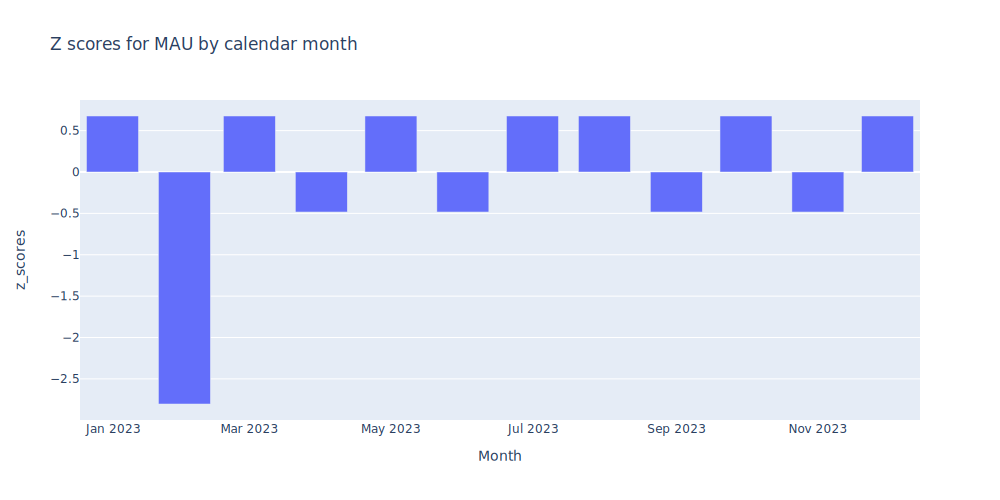

In [5]:
from sklearn.preprocessing import StandardScaler

# Calculating the z-score for each month
z_scores = StandardScaler().fit_transform(MAU_calendar_month['NumUsers'].values.reshape(-1, 1))
MAU_calendar_month['z_scores'] = z_scores
fig = px.bar(MAU_calendar_month, x='Month', y='z_scores', title='Z scores for MAU by calendar month', width=1000, height=500)
fig.show('svg')

Yikes, that's a lot of variation! Praciticioners commonly use a z-score of +/- 3 to determine if something is an outlier, and February is very close to that threshold with a z-score of -2.8! It's a good idea to have anomaly detection algorithms running on metrics (looking at a dashboard every day often isn't valuable, knowing when a metric changed significantly is), and February may trigger an alert despite not actually being an anomaly.

#### By rolling 28-day periods

Our calculation is going to be a little different here because we are going to calculate the 28 day window for each day that we have 28 days of data available. So we'll have a value for each given day rather than just one value per month.

This will also be fairly anticlimactic because we are using a constant rate of users per day so we're effectively plotting a horizontal line, but it is still worth looking at for a couple of reasons that we'll get to.

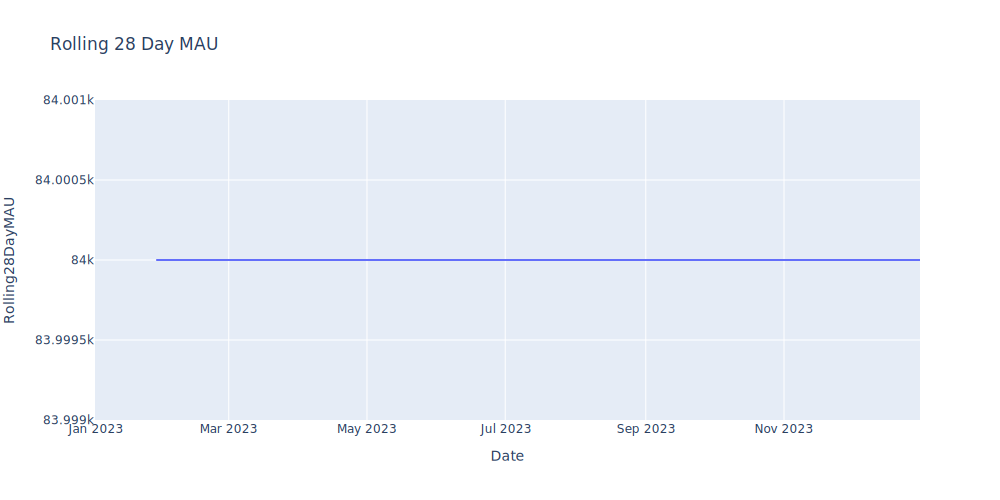

In [6]:
# Calculating the rolling 28-day MAU
df['Rolling28DayMAU'] = df['NumUsers'].rolling(28).sum()

# Plotting as a line plot
fig = px.line(df, x='Date', y='Rolling28DayMAU', title='Rolling 28 Day MAU', width=1000, height=500)
fig.show('svg')

# Removing the rolling 28 day MAU to keep data frame prints tidy since we won't be using it again
df.drop(columns=['Rolling28DayMAU'], inplace=True)

The first thing to point out is that we can't see the first 27 days because we're only including full 28 day periods. This is a common issue with rolling *n*-day periods, and it's why it's important to have a buffer of *n* days before you start reporting on metrics. This doesn't give us less information compared to tracking MAU by calendar month because the first full rolling 28 day MAU number would populate on January 29th (for January 1st-28th), and we would have to wait until February 1st to get the January MAU if using calendar months.

The second thing to mention is that this plot shows the rolling 28 day MAU *per day*, so this can be updated daily and show trends more clearly vs. tracking by calendar month.

#### Capturing Trends

We'll deviate from our data that has a constant rate of users per day to show how tracking by rolling 28 day periods can capture trends more quickly than tracking by calendar month. Let's say the app got a lot of positive press on July 1st that caused there to be 10% more users per day until the end of the year.

In [7]:
# Copying our data frame and temporarily adding a 10% bump in users starting on July 1st
df_temp = df[['Date', 'Month', 'NumUsers']].copy()
df_temp.loc[df_temp['Date'] >= '2023-07-01', 'NumUsers'] = df_temp['NumUsers'] * 1.05
df_temp

,Date,Month,NumUsers
0,2023-01-01,2023-01,3000
1,2023-01-02,2023-01,3000
2,2023-01-03,2023-01,3000
3,2023-01-04,2023-01,3000
4,2023-01-05,2023-01,3000
...,...,...,...
360,2023-12-27,2023-12,3150
361,2023-12-28,2023-12,3150
362,2023-12-29,2023-12,3150
363,2023-12-30,2023-12,3150


We'll go ahead and use the same plots to look at MAU as before, starting with MAU by calendar month.

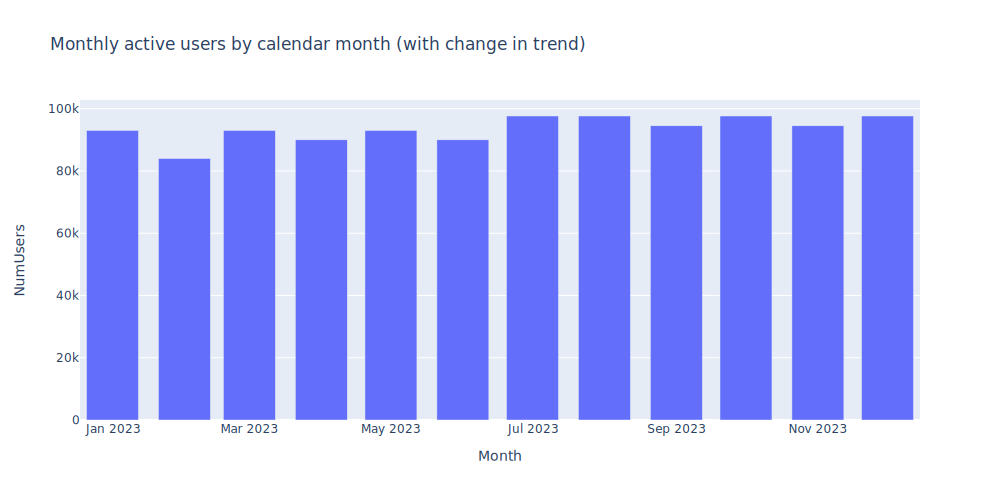

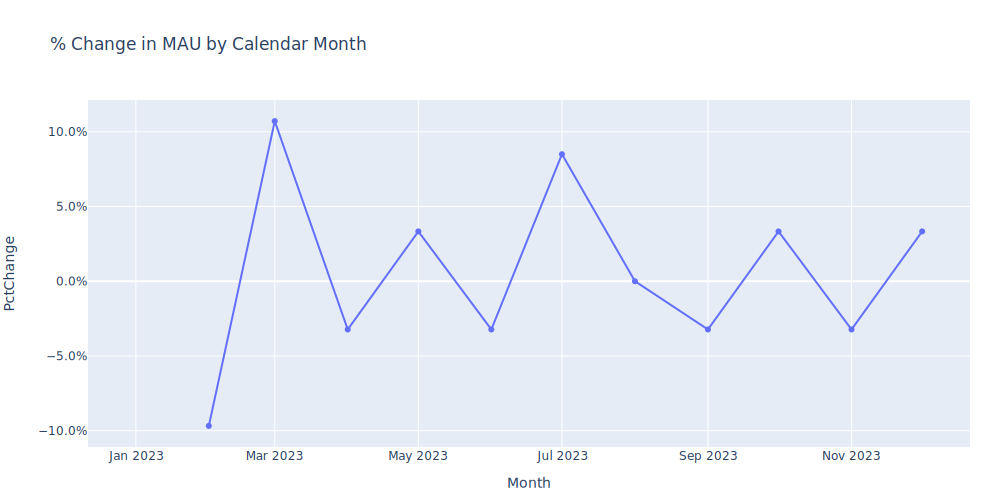

In [8]:
# Calculating MAU by calendar month
MAU_calendar_month = df_temp.groupby('Month')['NumUsers'].sum().reset_index()
fig = px.bar(MAU_calendar_month, x='Month', y='NumUsers', title='Monthly active users by calendar month (with change in trend)', width=1000, height=500)
fig.show('svg')

# Calculating the percent change for each month
MAU_calendar_month['PctChange'] = pct_change_of_series(MAU_calendar_month['NumUsers'])

# Plotting it
fig = px.line(MAU_calendar_month, x='Month', y='PctChange', markers=True,
              title='% Change in MAU by Calendar Month', width=1000, height=500)
fig.update_layout(margin=dict(r=30, b=30), yaxis_tickformat=".1%",)
fig.show('svg')

There is enough variation between each month that it's difficult to see the increase starting in July without staring at this plot for a while and comparing the MAU of each month with each other. Even when we include the percent changes from month to month, it only looks like July was a good month (but not as good as March), but the the one-time change in July no longer shows up after that month.

Now let's look at MAU by rolling 28 day periods.

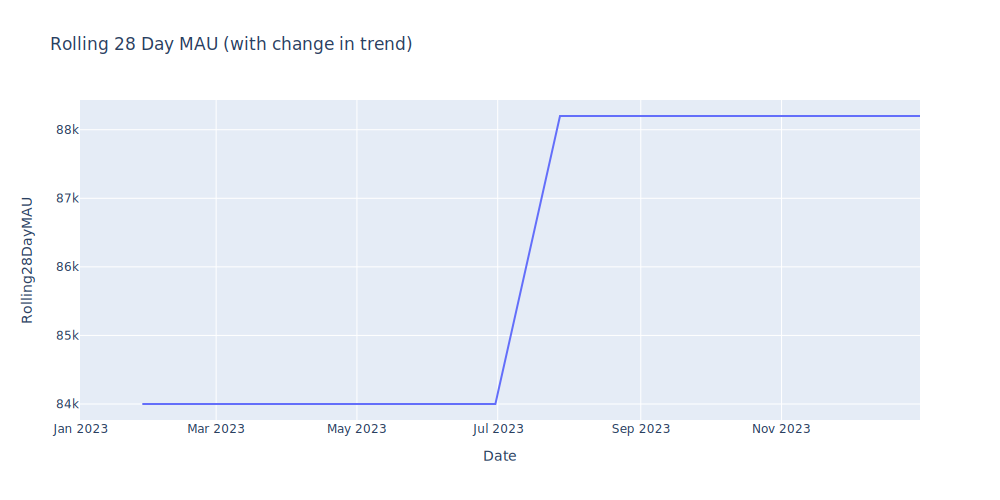

In [9]:
# Calculating the rolling 28-day MAU
df_temp['Rolling28DayMAU'] = df_temp['NumUsers'].rolling(28).sum()

# Plotting as a line plot
fig = px.line(df_temp, x='Date', y='Rolling28DayMAU', title='Rolling 28 Day MAU (with change in trend)', width=1000, height=500)
fig.show('svg')

It's extremely obvious here. We start seeing the increase in MAU the day it happens, and we can see it more clearly with each day until July 28th where everyone in the rolling 28 day MAU appeared after the increase happened.

### Next-month retention

This section is going to be a little more complex because we are going to simulate retention rates. We aren't going to change the actual retention rates, but the stochastic nature of the simulations will introduce a bit of noise.

As a reminder, we're using different retention definitions between the two methods, and we'll explore how these definitions affect the stability of the metric:
- **Next-month retention by calendar month:** The percentage of users who appeared in one calendar month that re-appeared in the following calendar month.
- **Rolling 28 day next-month retention:** The percentage of users who returned a month (28-56 days) later.

We'll start with calculating the probability of a user returning *n* days in the future. We'll use an exponentially decaying function since this often mimics real-world retention rates - users are less likely to return the longer they've been gone. We'll start with a 30% probability of returning on the next day and then decay it from there.

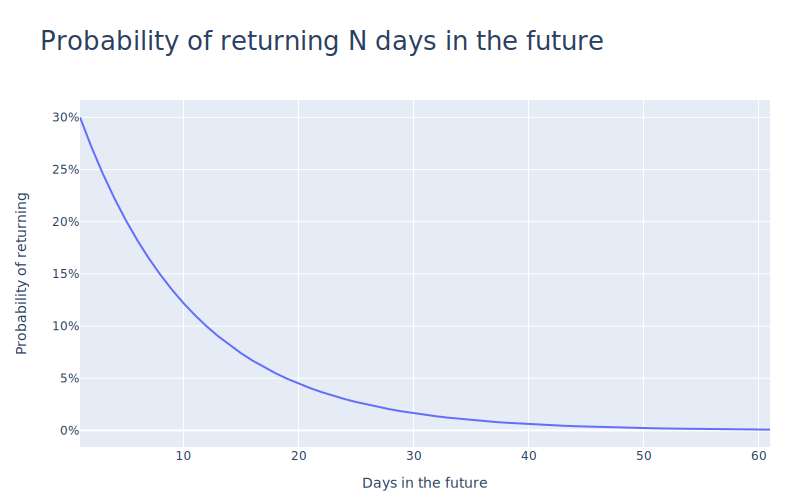

In [10]:
def exponential_decay(x, a, b):
    return a * np.exp(-b * x)


# Calculating the probability of returning n days in the future with an exponential decay function
initial_amount = 0.3
decay_rate = 0.10
retention_by_days_in_future = [exponential_decay(x, initial_amount, decay_rate) for x in range(0, 61)]
retention_by_days_in_future = np.insert(retention_by_days_in_future, 0, 1)

# Plotting the retention curve
fig = go.Figure()
fig.add_trace(go.Scatter(x=np.arange(1, 31*2), y=retention_by_days_in_future[1:], name='Decaying Retention Rate'))
fig.update_layout(
    width=800,
    height=500,
    margin=dict(r=30, b=30),
    yaxis_tickformat=".0%",
    title=dict(text="Probability of returning N days in the future", font=dict(size=26)),
    yaxis=dict(title='Probability of returning'),
    xaxis=dict(title='Days in the future')
)
fig.show('svg')

#### By calendar month

Before running the simulations, we need to determine the windows of time that users need to return in order to be counted as retained. Since monthly retention by calendar month means that the user just needs to return in the following calendar month, we need to determine the start and end dates of the next calendar month and get the number of days those are from the current date.

On a side note, measuring monthly retention this way biases the monthly retention rates to be *higher* because users can return sooner than a month to be counted as next-month retained.

In [11]:
# Adding the start and end of the next month before calculating the number of days until then
df['StartOfNextMonth'] = df['Date'] + pd.offsets.MonthBegin(1)
df['EndOfNextMonth'] = df['StartOfNextMonth'] + pd.offsets.MonthEnd(0)

# Calculating the number of days until the start and end of the next month
df['DaysUntilStartOfNextMonth'] = (df['StartOfNextMonth'] - df['Date']).dt.days
df['DaysUntilEndOfNextMonth'] = (df['EndOfNextMonth'] - df['Date']).dt.days

# Dropping the start/end of next month since they're no longer needed
df = df.drop(['StartOfNextMonth', 'EndOfNextMonth'], axis=1)

df.head()

,Date,MonthName,Month,MonthNum,NumUsers,DaysUntilStartOfNextMonth,DaysUntilEndOfNextMonth
0,2023-01-01,January,2023-01,1,3000,31,58
1,2023-01-02,January,2023-01,1,3000,30,57
2,2023-01-03,January,2023-01,1,3000,29,56
3,2023-01-04,January,2023-01,1,3000,28,55
4,2023-01-05,January,2023-01,1,3000,27,54


Next we'll simulate the number of retained users per day. We'll do this by sampling from a binomial distribution with the probability of returning on a given day and the number of users on that day. Since users can return on multiple days, we'll continue sampling for each successive day in the next-month window for users that did not return. We'll then sum the number of retained users for each day in the window to get the total number of retained users for that month.

We're also going to be repeating this exercise for the rolling 28-day periods, so we'll create a function that we can re-use.

In [12]:
def simulate_retention(num_users: int, period_start: int, period_end: int, retention_curve: np.ndarray) -> int:
    '''Simulating how many users will be retained over a period of time given a retention curve'''
    n_retained_users = 0
    # Sampling for each day in the period
    for day in range(period_start, period_end):
        # Only simulating if everyone isn't already retained
        if n_retained_users < num_users:
            n_retained_users += np.random.binomial(1, p=retention_curve[day], size=num_users - n_retained_users).sum()
    return n_retained_users


# Simulating monthly retention by day
df['NumRetainedUsers_calendar'] = df.apply(lambda x: simulate_retention(x['NumUsers'], x['DaysUntilStartOfNextMonth'], x['DaysUntilEndOfNextMonth'], retention_by_days_in_future), axis=1)
df.head(10)

,Date,MonthName,Month,MonthNum,NumUsers,DaysUntilStartOfNextMonth,DaysUntilEndOfNextMonth,NumRetainedUsers_calendar
0,2023-01-01,January,2023-01,1,3000,31,58,418
1,2023-01-02,January,2023-01,1,3000,30,57,469
2,2023-01-03,January,2023-01,1,3000,29,56,484
3,2023-01-04,January,2023-01,1,3000,28,55,556
4,2023-01-05,January,2023-01,1,3000,27,54,619
5,2023-01-06,January,2023-01,1,3000,26,53,660
6,2023-01-07,January,2023-01,1,3000,25,52,702
7,2023-01-08,January,2023-01,1,3000,24,51,755
8,2023-01-09,January,2023-01,1,3000,23,50,806
9,2023-01-10,January,2023-01,1,3000,22,49,947


You may already notice that the number of retained users is not constant for each row. This is not from the simulations, it's because users that start using the app further into the month can return in fewer days to count as retained. Before we calculate the monthly retention rates, here is a plot that shows the number of retained users per day to highlight this.

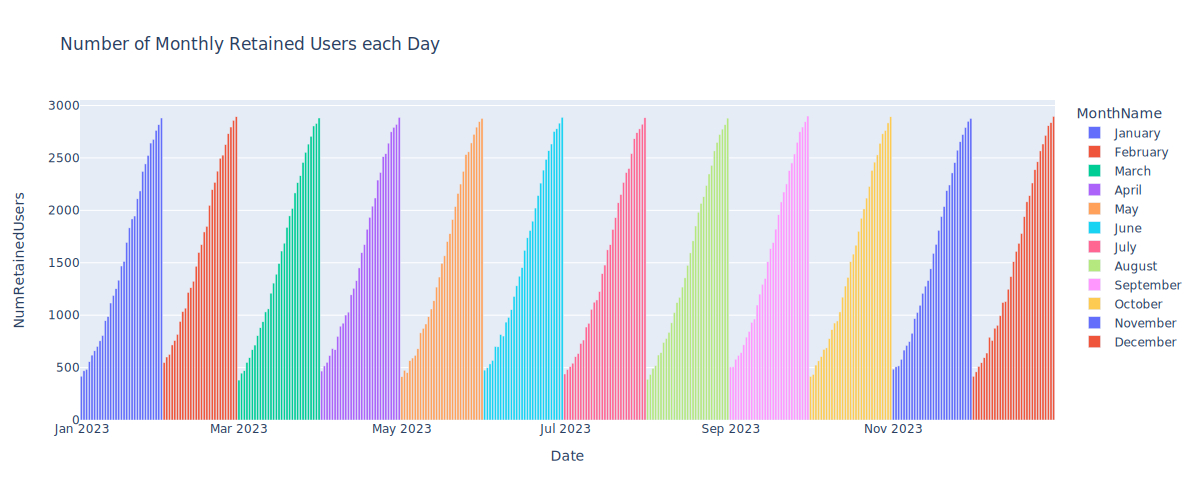

In [13]:
# Plotting monthly retention by day
fig = px.bar(df.rename(columns={'NumRetainedUsers_calendar': 'NumRetainedUsers'}), x='Date', y='NumRetainedUsers', color='MonthName',
             title='Number of Monthly Retained Users each Day', width=1200, height=500)
fig.show('svg')

As you can see, there are far more users retaining that start using the app towards the end of the month. This combined with the varying number of days in each month will create monthly retention rates that are unreliable. Let's take a look!

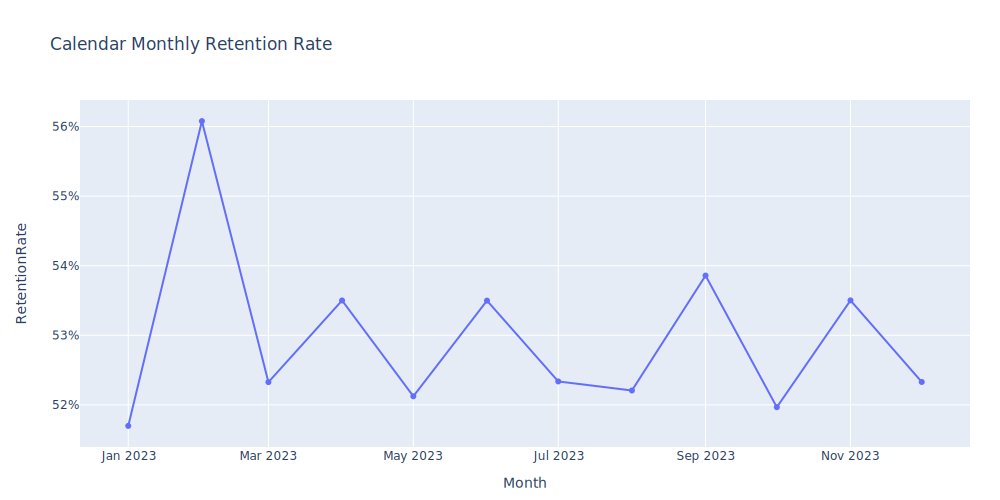

In [14]:
# Calculating the monthly retention rates
calendar_retention = df.groupby('Month')[['NumUsers', 'NumRetainedUsers_calendar']].sum().reset_index()
calendar_retention['RetentionRate'] = calendar_retention['NumRetainedUsers_calendar'] / calendar_retention['NumUsers']

# Plotting the monthly retention rate
fig = px.line(calendar_retention, x='Month', y='RetentionRate', markers=True,
              title='Calendar Monthly Retention Rate', width=1000, height=500)
fig.update_layout(margin=dict(r=30, b=30), yaxis_tickformat=".0%",)
fig.show('svg')

Oh dear, that's a lot of variation again! February especially stands out here. This is because February is the shortest month and March is one of the longest months, so users in February have fewer days before they can count as next-month retained while also having the largest window to return in order to count as retained. I saw this in the wild, and having to explain that was my motivation for writing this post :)

Let's quickly look at the percent change in retention rates for each month.

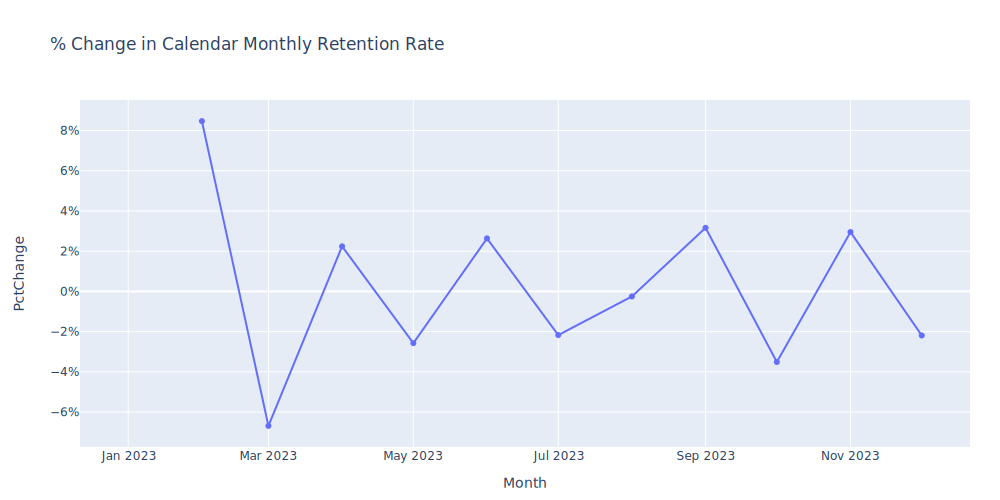

In [15]:
# Calculating the monthly pct change in retention rates and plotting it
calendar_retention['PctChange'] = pct_change_of_series(calendar_retention['RetentionRate'])
fig = px.line(calendar_retention, x='Month', y='PctChange', markers=True,
              title='% Change in Calendar Monthly Retention Rate', width=1000, height=500)
fig.update_layout(margin=dict(r=30, b=30), yaxis_tickformat=".0%",)
fig.show('svg')

As we saw with the percent changes in MAU, retention is changing by up to 8%! These are massive swings that would likely trigger an alert from an anomaly detection algorithm.

#### By rolling 28 day periods

As a reminder, our monthly retention calculation is different here. Rather than seeing who returned in the next month, we're seeing who returned a month (28-56 days) later. This will remove the seasonality from when the user started during a month. There will still be a bit of noise from the simulations we performed, but it should be far more stable than the monthly retention rates by calendar month.

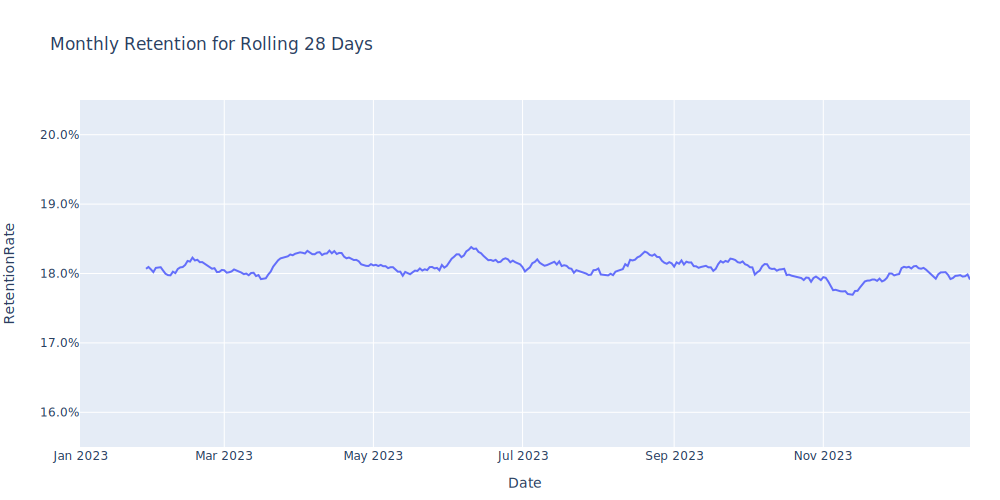

In [16]:
# Calculating the monthly retention rates for rolling 28-day periods
df['NumRetainedUsers_rolling'] = df.apply(lambda x: simulate_retention(x['NumUsers'], 28, 28*2, retention_by_days_in_future), axis=1)
rolling_retention = df[['Date', 'NumUsers', 'NumRetainedUsers_rolling']].copy()
rolling_retention['NumRollingUsers'] = rolling_retention['NumUsers'].rolling(28).sum()
rolling_retention['NumRollingRetainedUsers'] = rolling_retention['NumRetainedUsers_rolling'].rolling(28).sum()
rolling_retention['RetentionRate'] = rolling_retention['NumRollingRetainedUsers'] / rolling_retention['NumRollingUsers']

# Plotting the rolling 28 day monthly retention rate
fig = px.line(rolling_retention, x='Date', y='RetentionRate', #markers=True,
              title='Monthly Retention for Rolling 28 Days', width=1000, height=500)
fig.update_layout(margin=dict(r=30, b=30), yaxis_tickformat=".1%",
                  yaxis_range=[0.155, 0.205])  # Giving the y axis the same range for a more fair comparison
fig.show('svg')

There is some fluctuation as expected, but it generally stays within an approx. ~0.5% range. This is far more stable than the retention rates by calendar month which would often change by more than 1% from month to month.

As mentioned earlier, this is a different monthly retention calculation because we're measuring if the user actually came back a month later rather than just seeing if they came back the next month. As a result, the monthly retention rates here are much lower than the calendar monthly retention rates with an average of 18.1% vs. 53%.

#### Capturing Trends

Let's say there was regression from September 5th-7th that caused users to come back at 1/4 of their normal rate. We'll check our monthly retention rates for each method and see how easy this regression is to catch. We'll plot both here to make it easier to compare.

Note that this regression would be caught with a daily retention metric. Shorter term retention tends to be correlated to longer-term retention, but we're exclusively looking at longer-term retention here.

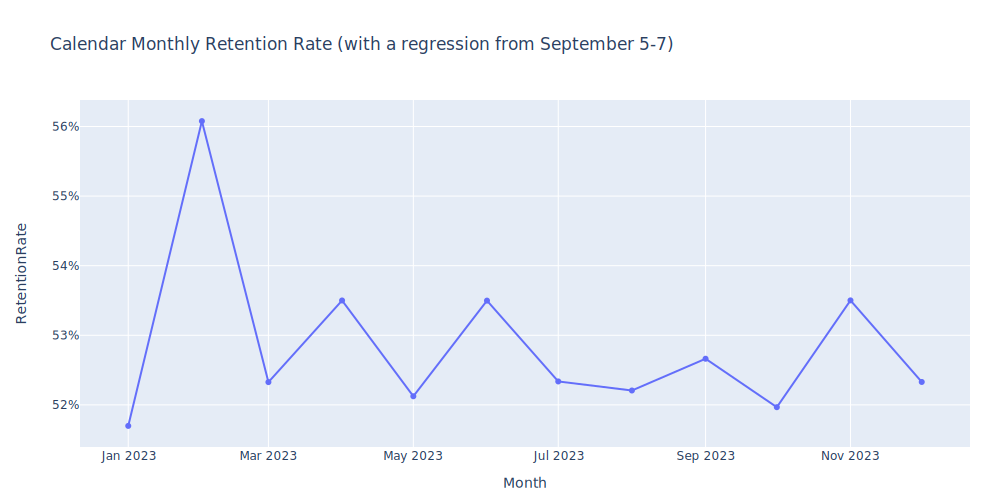

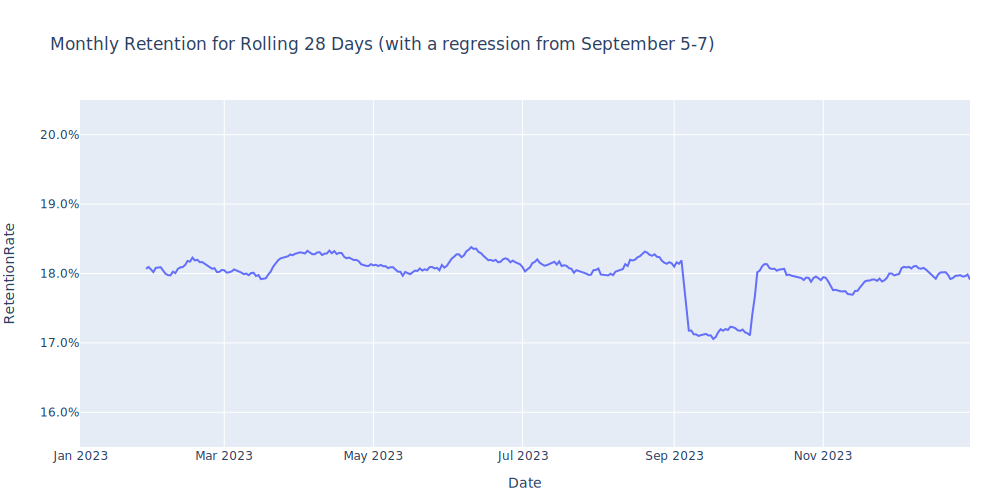

In [17]:
# Halving the retention rates for the regression
df_regression = df.copy()
df_regression.loc[(df['Date'] >= '2023-09-05') & (df_regression['Date'] <= '2023-09-7'), 'NumRetainedUsers_calendar'] = df_regression['NumRetainedUsers_calendar'] * 0.5
df_regression.loc[(df['Date'] >= '2023-09-05') & (df_regression['Date'] <= '2023-09-7'), 'NumRetainedUsers_rolling'] = df_regression['NumRetainedUsers_rolling'] * 0.5

# Re-calculating the calendar monthly retention rates
calendar_retention = df_regression.groupby('Month')[['NumUsers', 'NumRetainedUsers_calendar']].sum().reset_index()
calendar_retention['RetentionRate'] = calendar_retention['NumRetainedUsers_calendar'] / calendar_retention['NumUsers']

# Re-calculating the rolling 28 day monthly retention rates
rolling_retention = df_regression[['Date', 'NumUsers', 'NumRetainedUsers_rolling']].copy()
rolling_retention['NumRollingUsers'] = rolling_retention['NumUsers'].rolling(28).sum()
rolling_retention['NumRollingRetainedUsers'] = rolling_retention['NumRetainedUsers_rolling'].rolling(28).sum()
rolling_retention['RetentionRate'] = rolling_retention['NumRollingRetainedUsers'] / rolling_retention['NumRollingUsers']

# Plotting the monthly retention rate
fig = px.line(calendar_retention, x='Month', y='RetentionRate', markers=True,
              title='Calendar Monthly Retention Rate (with a regression from September 5-7)', width=1000, height=500)
fig.update_layout(margin=dict(r=30, b=30), yaxis_tickformat=".0%",)
fig.show('svg')

# Plotting the rolling 28 day monthly retention rate
fig = px.line(rolling_retention, x='Date', y='RetentionRate',
              title='Monthly Retention for Rolling 28 Days (with a regression from September 5-7)', width=1000, height=500)
fig.update_layout(margin=dict(r=30, b=30), yaxis_tickformat=".1%",
                  yaxis_range=[0.155, 0.205])  # Giving the y axis the same range for a more fair comparison
fig.show('svg')

As expected, it's substantially more obvious with the rolling 28 day periods. The monthly retention rate for September actually doesn't change much from August, so from a naive perspective it looks like September is a very normal month.

## Conclusion

Hopefully this post has convinced you that tracking metrics by rolling *n*-day periods is a better approach than tracking by calendar month. I demonstrated how tracking MAU and monthly retention by calendar month both creates trends that don't exist and hides trends that do exist. I also showed how tracking by rolling 28 day periods eliminates these false positives and can capture trends more quickly and accurately. I did not demonstrate the difference in timeliness between the two methods, but just remember that the calendar month metrics won't update until the beginning of the next month while the rolling 28 day period metrics can update every day.

We didn't get to implementation details for metrics like MAU and monthly retention for real-world cases where users will use the app or visit the website more frequently than once a month. This is trivial with MAU since you can just count the distinct number of users within the past *n* days, but it gets a little more complex with retention. The main decision is whether or not you want to count users multiple times since more active users can skew the retention rates higher. I'd recommend discussing this with stakeholders to determine what makes the most sense for your business.

If you have any questions or comments, please feel free to reach out to me on by email or on [LinkedIn](https://www.linkedin.com/in/alexioannides/). Thanks for reading!